# Functions

In [2]:
import pandas as pd
import numpy as np
import os

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt

import requests
import time
from tqdm import tqdm

In [1]:
import pandas as pd
import math

# df1 = pd.read_csv('/Users/bowen/Desktop/multi_omics_Analysis/2408_pea 2/PeaEndosperm.csv')
df2 = pd.read_csv('/Users/bowen/Desktop/multi_omics_Analysis/2408_pea 2/PeaEmbryo.csv')

# data1 = df1['External Identifier'].to_list()
data2 = df2['External Identifier'].to_list()
# data = data1 + data2
data = data2

# Filter out NaN values and remove duplicates
cleaned_data = list(set([x for x in data if x != 'nan' and not isinstance(x, float) or not math.isnan(x)]))

# print(cleaned_data)

In [3]:
def compare_groups(data, group1_prefix, group2_prefix):
    # Filter columns for each group
    group1_columns = [col for col in data.columns if col.startswith(group1_prefix)]
    group2_columns = [col for col in data.columns if col.startswith(group2_prefix)]
    
    # Calculate mean for each group
    data[f'{group1_prefix}_mean'] = data[group1_columns].mean(axis=1)
    data[f'{group2_prefix}_mean'] = data[group2_columns].mean(axis=1)
    
    # Calculate fold change
    data['Fold_Change'] = data[f'{group1_prefix}_mean'] / data[f'{group2_prefix}_mean']
    
    # Perform t-test
    group1_values = data[group1_columns].values
    group2_values = data[group2_columns].values
    t_stat, p_values = ttest_ind(group1_values, group2_values, axis=1, equal_var=False)
    data['P_Value'] = p_values
    
    # Apply FDR correction
    _, p_adj, _, _ = multipletests(data['P_Value'], method='fdr_bh')
    data['FDR_P_Value'] = p_adj
    
    # Keeping necessary columns
    necessary_columns = ['Identification Level', 'External Identifier', 'Compound', 
                         f'{group1_prefix}_mean', f'{group2_prefix}_mean', 'Fold_Change', 'P_Value', 'FDR_P_Value']
    final_data = data[necessary_columns]
    
    return final_data





def get_dam(df):
    filtered_data = df[(df['P_Value'] <= 0.05) & 
                            ((df['Fold_Change'] >= 1.5) | (df['Fold_Change'] <= (1/1.5)))]
    sorted_data = filtered_data.sort_values(by='Fold_Change', ascending=False)
    return sorted_data





def filter_and_extract_compounds(df, fold_change_threshold=1.0, p_value_threshold=0.05):
    filtered_df = df[((df['Fold_Change'] > fold_change_threshold) | (df['Fold_Change'] < 1.0 / fold_change_threshold)) & (df['P_Value'] < p_value_threshold)]
    compounds = filtered_df['Compound'].tolist()
    
    return compounds




def plot_volcano(dfs, compound, save_path=None):
    """
    Plot volcano plots based on the provided list of dataframes, highlighting a specific compound.
    
    Parameters:
    - dfs (list of DataFrame): A list of input dataframes, each containing 'Fold_Change', 'P_Value', and 'Compounds' columns.
    - compound (str): The name of the compound to highlight.
    - save_path (str, optional): The path where the plot should be saved. If None, the plot won't be saved.
    
    Returns:
    - None: Displays the volcano plots or saves them to the provided path.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Set font size for the plot
    plt.rcParams.update({'font.size': 40})  # Adjust overall font size

    # Determine layout based on number of dataframes
    n_plots = len(dfs)
    if n_plots == 3:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    elif n_plots == 4:
        fig, axes = plt.subplots(1, 4, figsize=(24, 5))
    else:
        raise ValueError("This function only supports lists with 3 or 4 dataframes.")

    # Set thresholds for highlighting
    fc_high_threshold = np.log2(1.5)  # Convert Fold Change threshold to log2 scale
    fc_low_threshold = np.log2(0.5)   # Convert Fold Change threshold to log2 scale
    p_value_threshold = 0.05

    # Loop over each dataframe and its corresponding subplot
    for i, df in enumerate(dfs):
        ax = axes[i]
        
        # Convert Fold Change values to log2 scale for the plot
        df['Log2_Fold_Change'] = np.log2(df['Fold_Change'])

        # Default points
        default_mask = ~((df['Log2_Fold_Change'] > fc_high_threshold) & (df['P_Value'] < p_value_threshold)) & \
                       ~((df['Log2_Fold_Change'] < fc_low_threshold) & (df['P_Value'] < p_value_threshold))
        ax.scatter(x=df.loc[default_mask, 'Log2_Fold_Change'], 
                   y=-np.log10(df.loc[default_mask, 'P_Value']), 
                   s=10, color="lightgray", alpha=0.7, label="Not significant")

        # Highlight points with Log2 Fold Change > log2(1.5) and P_Value < 0.05
        high_mask = (df['Log2_Fold_Change'] > fc_high_threshold) & (df['P_Value'] < p_value_threshold)
        ax.scatter(x=df.loc[high_mask, 'Log2_Fold_Change'], 
                   y=-np.log10(df.loc[high_mask, 'P_Value']), 
                   s=40, color="darkorange", alpha=0.7, label="up-accumulated")

        # Highlight points with Log2 Fold Change < log2(0.5) and P_Value < 0.05
        low_mask = (df['Log2_Fold_Change'] < fc_low_threshold) & (df['P_Value'] < p_value_threshold)
        ax.scatter(x=df.loc[low_mask, 'Log2_Fold_Change'], 
                   y=-np.log10(df.loc[low_mask, 'P_Value']), 
                   s=40, color="darkblue", alpha=0.7, label="down-accumulated")

        # Highlight specific compound
        compound_mask = (df['Compound'] == compound)
        ax.scatter(x=df.loc[compound_mask, 'Log2_Fold_Change'], 
                   y=-np.log10(df.loc[compound_mask, 'P_Value']), 
                   s=80, color="#C94411", alpha=1)  # Larger and more visible
        for j in df[compound_mask].index:
            ax.annotate(compound, (df.at[j, 'Log2_Fold_Change'], -np.log10(df.at[j, 'P_Value'])), color="#C94411")

        # Labels, title and legends for each subplot
        ax.set_xlabel("Log2 Fold Change", fontsize=20)
        ax.set_ylabel("-log10(P Value)", fontsize=20)
        ax.axvline(fc_high_threshold, color="darkorange", linestyle="--")
        ax.axvline(fc_low_threshold, color="darkblue", linestyle="--")
        ax.axhline(-np.log10(p_value_threshold), color="#DCB7A3", linestyle="--")  # P-value threshold line
#         ax.legend(fontsize=20)

        # Set tick size for better visibility
        ax.tick_params(axis='both', which='major', labelsize=20)

    # Adjust layout and spacing
    plt.tight_layout()

    # Save or display the plot
    if save_path:
        plt.savefig(save_path, dpi=700)
    plt.show()

# TS

### TS sFE

In [4]:
df = pd.read_csv('/Users/bowen/Desktop/multi_omics_Analysis/2408_pea 2/PeaEmbryo.csv')

In [5]:
sFED2_vs_sFED1 = compare_groups(df, 'sFED2', 'sFED1')
sFED3_vs_sFED2 = compare_groups(df, 'sFED3', 'sFED2')
sFED4_vs_sFED3 = compare_groups(df, 'sFED4', 'sFED3')

# dam_sFED2_vs_sFED1 = get_dam(sFED2_vs_sFED1)
# dam_sFED3_vs_sFED2 = get_dam(sFED3_vs_sFED2)
# dam_sFED4_vs_sFED3 = get_dam(sFED4_vs_sFED3)


# base_path = '/Users/bowen/Desktop/multi_omics_analysis/2408_pea 2/scripts/240628_Enrichment_Result/TS_sFE'

# # Define the file paths based on the base path
# path1 = os.path.join(base_path, 'sFEnD2_vs_sFEnD1/DAM_sFED2_vs_sFED1.csv')
# path2 = os.path.join(base_path, 'sFEnD3_vs_sFEnD2/DAM_sFED3_vs_sFED2.csv')
# path3 = os.path.join(base_path, 'sFEnD4_vs_sFEnD3/DAM_sFED4_vs_sFED3.csv')


# os.makedirs(os.path.dirname(path1), exist_ok=True)
# os.makedirs(os.path.dirname(path2), exist_ok=True)
# os.makedirs(os.path.dirname(path3), exist_ok=True)


# dam_sFED2_vs_sFED1.to_csv(path1, index=False)
# dam_sFED3_vs_sFED2.to_csv(path2, index=False)
# dam_sFED4_vs_sFED3.to_csv(path3, index=False)

/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log2_Fold_Change'] = np.log2(df['Fold_Change'])
/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log2_Fold_Change'] = np.log2(df['Fold_Change'])
/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

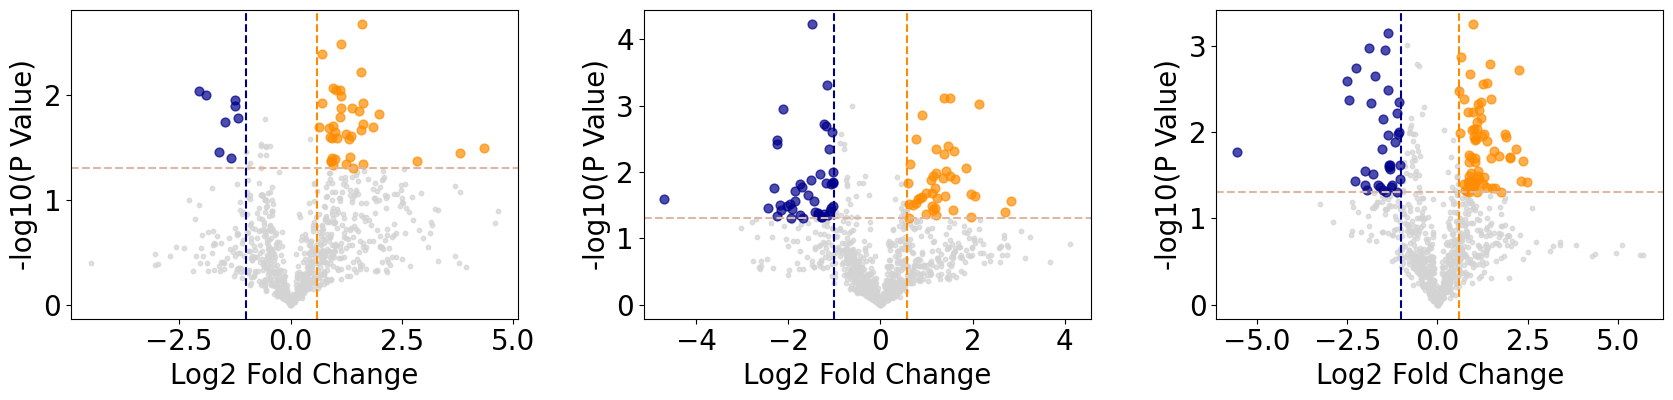

In [6]:
plot_volcano([sFED2_vs_sFED1, sFED3_vs_sFED2, sFED4_vs_sFED3], None, save_path="/Users/bowen/Desktop/multi_omics_analysis/2408_pea 2/scripts/240924_Enrichment_Result/TS_sFE/volcano_plot.pdf")

### TS sME

In [7]:
sMED2_vs_sMED1 = compare_groups(df, 'sMED2', 'sMED1')
sMED3_vs_sMED2 = compare_groups(df, 'sMED3', 'sMED2')
sMED4_vs_sMED3 = compare_groups(df, 'sMED4', 'sMED3')

# dam_sMED2_vs_sMED1 = get_dam(sMED2_vs_sMED1)
# dam_sMED3_vs_sMED2 = get_dam(sMED3_vs_sMED2)
# dam_sMED4_vs_sMED3 = get_dam(sMED4_vs_sMED3)


# base_path = '/Users/bowen/Desktop/multi_omics_analysis/2408_pea 2/scripts/240924_Enrichment_Result/TS_sME'

# # Define the file paths based on the base path
# path1 = os.path.join(base_path, 'sMED2_vs_sMED1/DAM_sMED2_vs_sMED1.csv')
# path2 = os.path.join(base_path, 'sMED3_vs_sMED2/DAM_sMED3_vs_sMED2.csv')
# path3 = os.path.join(base_path, 'sMED4_vs_sMED3/DAM_sMED4_vs_sMED3.csv')


# os.makedirs(os.path.dirname(path1), exist_ok=True)
# os.makedirs(os.path.dirname(path2), exist_ok=True)
# os.makedirs(os.path.dirname(path3), exist_ok=True)


# dam_sMED2_vs_sMED1.to_csv(path1, index=False)
# dam_sMED3_vs_sMED2.to_csv(path2, index=False)
# dam_sMED4_vs_sMED3.to_csv(path3, index=False)

/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log2_Fold_Change'] = np.log2(df['Fold_Change'])
/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log2_Fold_Change'] = np.log2(df['Fold_Change'])
/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

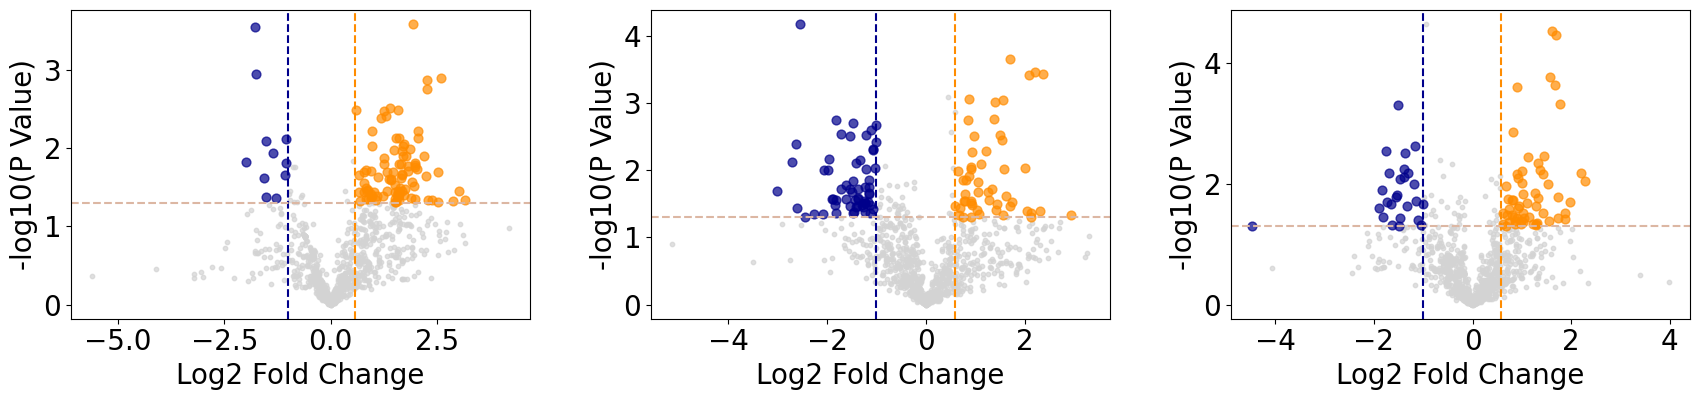

In [8]:
data_list = [sMED2_vs_sMED1, sMED3_vs_sMED2, sMED4_vs_sMED3]
volcano_path = "/Users/bowen/Desktop/multi_omics_analysis/2408_pea 2/scripts/240924_Enrichment_Result/TS_sME/volcano_plot.pdf"
plot_volcano(data_list, None, save_path=volcano_path)

### TS sFEn

In [9]:
df = pd.read_csv('/Users/bowen/Desktop/multi_omics_Analysis/2408_pea 2/PeaEndosperm.csv')

In [10]:
sFEn2_vs_sFEn1 = compare_groups(df, 'sFEnD2', 'sFEnD1')
sFEn3_vs_sFEn2 = compare_groups(df, 'sFEnD3', 'sFEnD2')
sFEn4_vs_sFEn3 = compare_groups(df, 'sFEnD4', 'sFEnD3')

# dam_sFEn2_vs_sFEn1 = get_dam(sFEn2_vs_sFEn1)
# dam_sFEn3_vs_sFEn2 = get_dam(sFEn3_vs_sFEn2)
# dam_sFEn4_vs_sFEn3 = get_dam(sFEn4_vs_sFEn3)

# base_path = '/Users/bowen/Desktop/multi_omics_analysis/2408_pea 2/scripts/240628_Enrichment_Result/TS_sFEn'

# # Define the file paths based on the base path
# path1 = os.path.join(base_path, 'sFEnD2_vs_sFEnD1/DAM_sFEnD2_vs_sFEnD1.csv')
# path2 = os.path.join(base_path, 'sFEnD3_vs_sFEnD2/DAM_sFEnD3_vs_sFEnD2.csv')
# path3 = os.path.join(base_path, 'sFEnD4_vs_sFEnD3/DAM_sFEnD4_vs_sFEnD3.csv')

# os.makedirs(os.path.dirname(path1), exist_ok=True)
# os.makedirs(os.path.dirname(path2), exist_ok=True)
# os.makedirs(os.path.dirname(path3), exist_ok=True)

# dam_sFEn2_vs_sFEn1.to_csv(path1, index=False)
# dam_sFEn3_vs_sFEn2.to_csv(path2, index=False)
# dam_sFEn4_vs_sFEn3.to_csv(path3, index=False)

/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log2_Fold_Change'] = np.log2(df['Fold_Change'])
/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log2_Fold_Change'] = np.log2(df['Fold_Change'])
/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

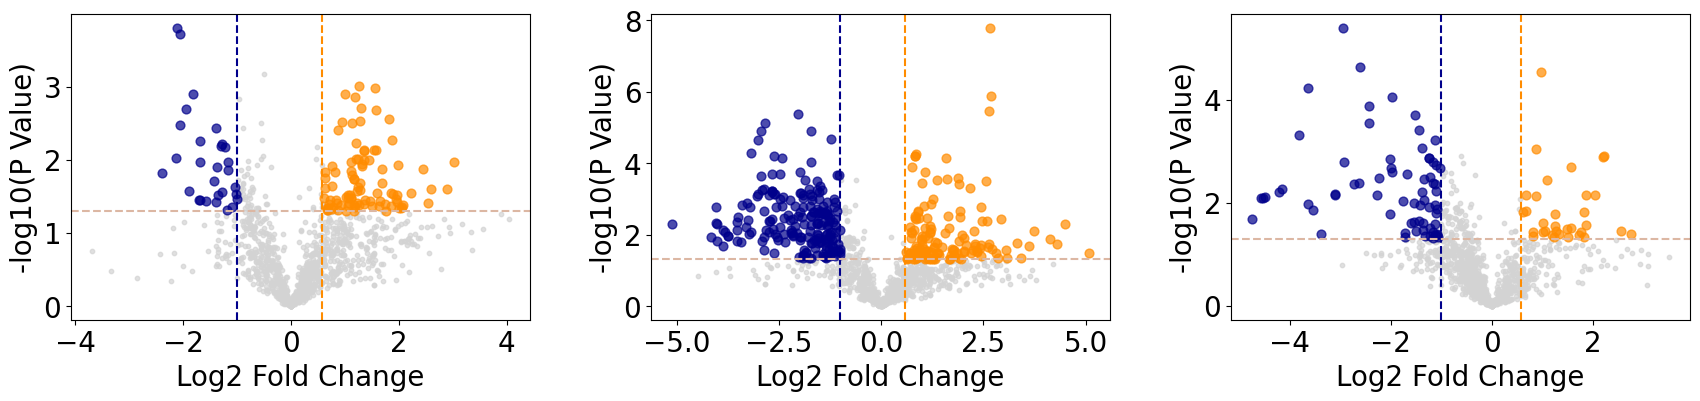

In [11]:
data_list = [sFEn2_vs_sFEn1 , sFEn3_vs_sFEn2, sFEn4_vs_sFEn3]
volcano_path = "/Users/bowen/Desktop/multi_omics_analysis/2408_pea 2/scripts/240924_Enrichment_Result/TS_sFEn/volcano_plot.pdf"
plot_volcano(data_list, None, save_path=volcano_path)

### TS sMEn

In [12]:
sMEn2_vs_sMEn1 = compare_groups(df, 'sMEnD2', 'sMEnD1')
sMEn3_vs_sMEn2 = compare_groups(df, 'sMEnD3', 'sMEnD2')
sMEn4_vs_sMEn3 = compare_groups(df, 'sMEnD4', 'sMEnD3')

# dam_sMEn2_vs_sMEn1 = get_dam(sMEn2_vs_sMEn1)
# dam_sMEn3_vs_sMEn2 = get_dam(sMEn3_vs_sMEn2)
# dam_sMEn4_vs_sMEn3 = get_dam(sMEn4_vs_sMEn3)

# base_path = '/Users/bowen/Desktop/multi_omics_analysis/2408_pea 2/scripts/240628_Enrichment_Result/TS_sMEn'

# # Define the file paths based on the base path
# path1 = os.path.join(base_path, 'sMEnD2_vs_sMEnD1/DAM_sMEnD2_vs_sMEnD1.csv')
# path2 = os.path.join(base_path, 'sMEnD3_vs_sMEnD2/DAM_sMEnD3_vs_sMEnD2.csv')
# path3 = os.path.join(base_path, 'sMEnD4_vs_sMEnD3/DAM_sMEnD4_vs_sMEnD3.csv')

# os.makedirs(os.path.dirname(path1), exist_ok=True)
# os.makedirs(os.path.dirname(path2), exist_ok=True)
# os.makedirs(os.path.dirname(path3), exist_ok=True)

# dam_sMEn2_vs_sMEn1.to_csv(path1, index=False)
# dam_sMEn3_vs_sMEn2.to_csv(path2, index=False)
# dam_sMEn4_vs_sMEn3.to_csv(path3, index=False)

/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log2_Fold_Change'] = np.log2(df['Fold_Change'])
/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log2_Fold_Change'] = np.log2(df['Fold_Change'])
/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

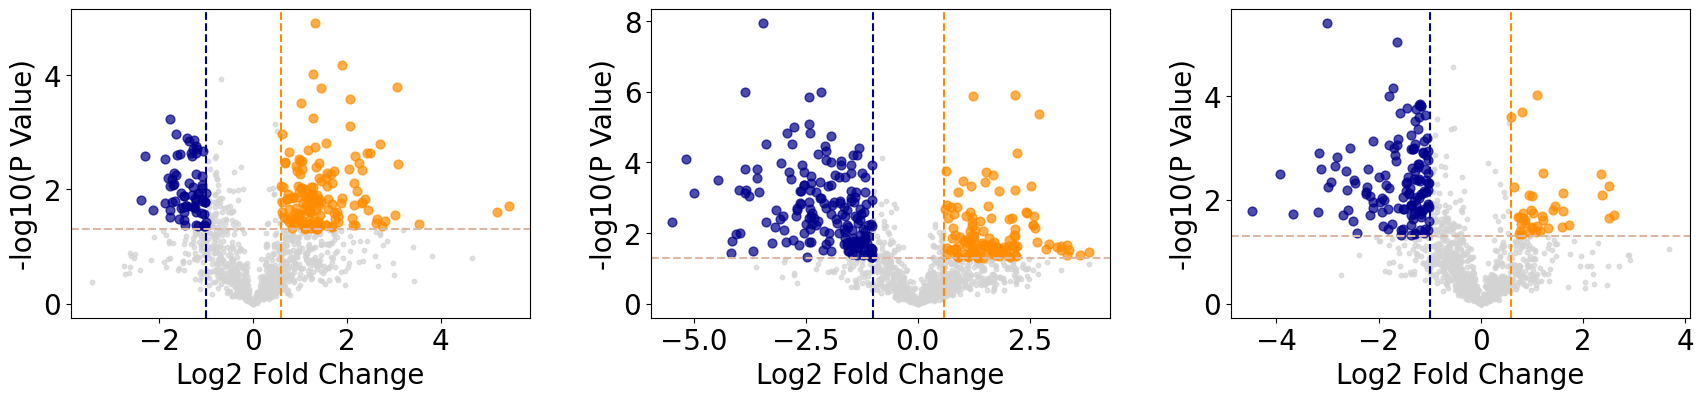

In [13]:
data_list = [sMEn2_vs_sMEn1 , sMEn3_vs_sMEn2, sMEn4_vs_sMEn3]
volcano_path = "/Users/bowen/Desktop/multi_omics_analysis/2408_pea 2/scripts/240924_Enrichment_Result/TS_sMEn/volcano_plot.pdf"
plot_volcano(data_list, None, save_path=volcano_path)

# Two stages

### sFE vs sME

In [14]:
df = pd.read_csv('/Users/bowen/Desktop/multi_omics_Analysis/2408_pea 2/PeaEmbryo.csv')

In [15]:
# # Get all the KEGG ID
# c_list = df[df['External Identifier'].notna() & df['External Identifier'].str.startswith('C')]['External Identifier'].tolist()
# # Print the list
# print(c_list)

In [16]:
# Perform the comparisons for "FE" vs "ME"
sFED1_vs_sMED1 = compare_groups(df, 'sFED1', 'sMED1')
sFED2_vs_sMED2 = compare_groups(df, 'sFED2', 'sMED2')
sFED3_vs_sMED3 = compare_groups(df, 'sFED3', 'sMED3')
sFED4_vs_sMED4 = compare_groups(df, 'sFED4', 'sMED4')

# # Get DAM (Differential Abundance Markers) for each comparison
# dam_sFED1_vs_sMED1 = get_dam(sFED1_vs_sMED1)
# dam_sFED2_vs_sMED2 = get_dam(sFED2_vs_sMED2)
# dam_sFED3_vs_sMED3 = get_dam(sFED3_vs_sMED3)
# dam_sFED4_vs_sMED4 = get_dam(sFED4_vs_sMED4)

# # Define the base path
# base_path = '/Users/bowen/Desktop/multi_omics_analysis/2408_pea 2/scripts/240628_Enrichment_Result/sFE_vs_sME'

# # Define the file paths based on the base path
# path1 = os.path.join(base_path, 'sFED1_vs_sMED1/DAM_sFED1_vs_sMED1.csv')
# path2 = os.path.join(base_path, 'sFED2_vs_sMED2/DAM_sFED2_vs_sMED2.csv')
# path3 = os.path.join(base_path, 'sFED3_vs_sMED3/DAM_sFED3_vs_sMED3.csv')
# path4 = os.path.join(base_path, 'sFED4_vs_sMED4/DAM_sFED4_vs_sMED4.csv')

# # Create the directories if they don't exist
# os.makedirs(os.path.dirname(path1), exist_ok=True)
# os.makedirs(os.path.dirname(path2), exist_ok=True)
# os.makedirs(os.path.dirname(path3), exist_ok=True)
# os.makedirs(os.path.dirname(path4), exist_ok=True)

# # Save the DAM results to CSV files
# dam_sFED1_vs_sMED1.to_csv(path1, index=False)
# dam_sFED2_vs_sMED2.to_csv(path2, index=False)
# dam_sFED3_vs_sMED3.to_csv(path3, index=False)
# dam_sFED4_vs_sMED4.to_csv(path4, index=False)

/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log2_Fold_Change'] = np.log2(df['Fold_Change'])
/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log2_Fold_Change'] = np.log2(df['Fold_Change'])
/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

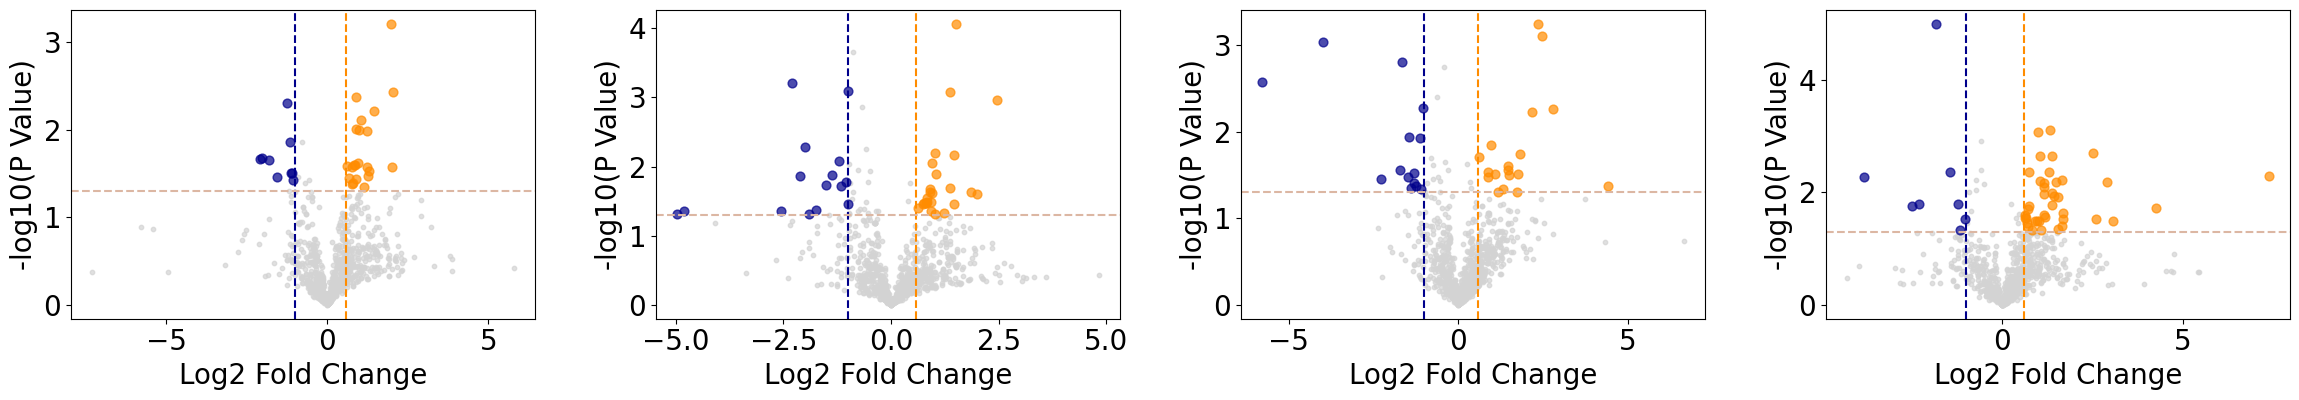

In [17]:
data_list = [sFED1_vs_sMED1, sFED2_vs_sMED2, sFED3_vs_sMED3, sFED4_vs_sMED4]
volcano_path = "/Users/bowen/Desktop/multi_omics_analysis/2408_pea 2/scripts/240924_Enrichment_Result/sFE_vs_sME/volcano_plot.pdf"
plot_volcano(data_list, None, save_path=volcano_path)

### sFEn vs sMEn

In [18]:
df = pd.read_csv('/Users/bowen/Desktop/multi_omics_Analysis/2408_pea 2/PeaEndosperm.csv')

In [19]:
# Perform the comparisons for "FEn" vs "MEn"
sFEnD1_vs_sMEnD1 = compare_groups(df, 'sFEnD1', 'sMEnD1')
sFEnD2_vs_sMEnD2 = compare_groups(df, 'sFEnD2', 'sMEnD2')
sFEnD3_vs_sMEnD3 = compare_groups(df, 'sFEnD3', 'sMEnD3')
sFEnD4_vs_sMEnD4 = compare_groups(df, 'sFEnD4', 'sMEnD4')

# # Get DAM (Differential Abundance Markers) for each comparison
# dam_sFEnD1_vs_sMEnD1 = get_dam(sFEnD1_vs_sMEnD1)
# dam_sFEnD2_vs_sMEnD2 = get_dam(sFEnD2_vs_sMEnD2)
# dam_sFEnD3_vs_sMEnD3 = get_dam(sFEnD3_vs_sMEnD3)
# dam_sFEnD4_vs_sMEnD4 = get_dam(sFEnD4_vs_sMEnD4)

# # Define the base path
# base_path = '/Users/bowen/Desktop/multi_omics_analysis/2408_pea 2/scripts/240628_Enrichment_Result/sFEn_vs_sMEn'

# # Define the file paths based on the base path
# path1 = os.path.join(base_path, 'sFEnD1_vs_sMEnD1/DAM_sFEnD1_vs_sMEnD1.csv')
# path2 = os.path.join(base_path, 'sFEnD2_vs_sMEnD2/DAM_sFEnD2_vs_sMEnD2.csv')
# path3 = os.path.join(base_path, 'sFEnD3_vs_sMEnD3/DAM_sFEnD3_vs_sMEnD3.csv')
# path4 = os.path.join(base_path, 'sFEnD4_vs_sMEnD4/DAM_sFEnD4_vs_sMEnD4.csv')

# # Create the directories if they don't exist
# os.makedirs(os.path.dirname(path1), exist_ok=True)
# os.makedirs(os.path.dirname(path2), exist_ok=True)
# os.makedirs(os.path.dirname(path3), exist_ok=True)
# os.makedirs(os.path.dirname(path4), exist_ok=True)

# # Save the DAM results to CSV files
# dam_sFEnD1_vs_sMEnD1.to_csv(path1, index=False)
# dam_sFEnD2_vs_sMEnD2.to_csv(path2, index=False)
# dam_sFEnD3_vs_sMEnD3.to_csv(path3, index=False)
# dam_sFEnD4_vs_sMEnD4.to_csv(path4, index=False)

/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log2_Fold_Change'] = np.log2(df['Fold_Change'])
/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log2_Fold_Change'] = np.log2(df['Fold_Change'])
/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

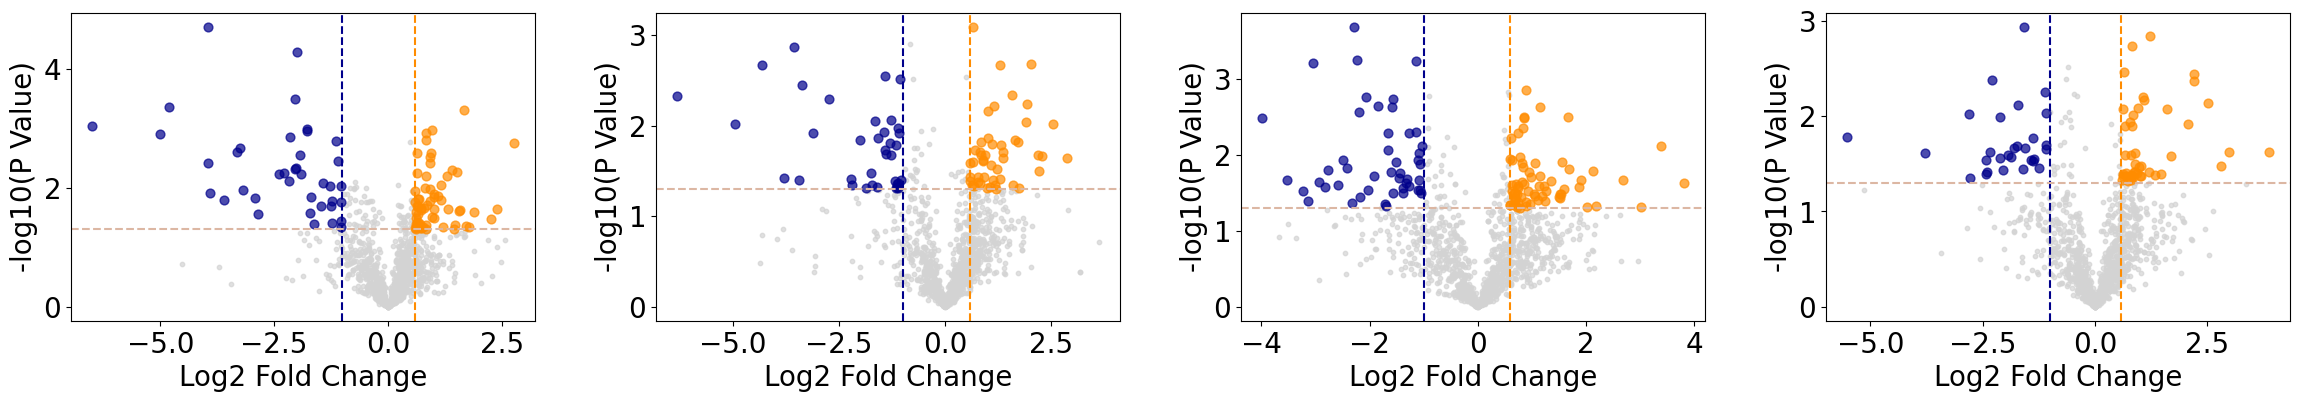

In [20]:
data_list = [sFEnD1_vs_sMEnD1, sFEnD2_vs_sMEnD2, sFEnD3_vs_sMEnD3, sFEnD4_vs_sMEnD4]
volcano_path = "/Users/bowen/Desktop/multi_omics_analysis/2408_pea 2/scripts/240924_Enrichment_Result/sFEn_vs_sMEn/volcano_plot.pdf"
plot_volcano(data_list, None, save_path=volcano_path)

### sFEn vs sFE

In [21]:
df1 = pd.read_csv('/Users/bowen/Desktop/multi_omics_Analysis/2408_pea 2/PeaEndosperm.csv')
df2 = pd.read_csv('/Users/bowen/Desktop/multi_omics_Analysis/2408_pea 2/PeaEmbryo.csv')
df = pd.merge(df1, df2, on=['Compound', 'Identification Level','External Identifier'], how='outer')
df = df.dropna(thresh=len(df.columns)-5)
df

,Identification Level,External Identifier,Compound,sFEnD1,sFEnD1.1,sFEnD1.2,sFEnD2,sFEnD2.1,sFEnD2.2,sFEnD3,...,sMED2.2,sMED3,sMED3.1,sMED3.2,sMED4,sMED4.1,sMED4.2,QC_y,QC.1_y,QC.2_y
1,Tier 2,C00021,S-Adenosyl-L-homocysteine,0.240,0.482,0.3210,0.268,0.2370,0.650,1.0420,...,0.220,0.704,0.1330,0.3140,0.6270,0.6300,0.9410,0.9280,0.9160,0.8780
4,Tier 1,C00047,Lysine,0.661,0.955,0.5970,0.636,0.7590,2.070,0.9270,...,0.026,0.232,0.1000,0.1130,0.3690,0.5320,0.8600,0.8970,0.8700,0.8740
6,Tier 2,C00072,Isomer 1 of Ascorbic acid,1.279,1.522,1.0030,3.264,2.9620,2.881,1.8610,...,1.887,0.554,0.7000,0.3990,0.1760,0.1910,0.2300,1.4550,1.3540,1.2030
8,Tier 2,C00122,Isomer 2 of Fumaric acid,0.398,0.063,0.0560,0.561,0.5900,0.885,0.5820,...,1.332,1.352,1.1670,1.1580,0.4710,1.4700,1.0030,1.1870,1.0620,1.0670
10,Tier 2,C00122,Isomer 1 of Fumaric acid,0.428,0.079,0.0760,0.605,0.6220,0.927,0.6370,...,1.334,1.224,1.1550,1.1250,0.5020,1.4520,1.0320,1.2290,1.0610,1.0740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,Tier 2,C16344,Heptadecatrienoic acid,1.570,2.150,1.7970,1.316,1.3630,0.788,1.3650,...,1.748,1.819,2.0840,1.2910,1.1440,1.1790,1.7580,1.0580,1.0710,1.0850
1154,Tier 2,C00219,Arachidonic acid,1.454,1.716,1.5590,1.183,0.8637,0.778,1.2800,...,0.484,0.379,0.4640,0.3580,0.3888,0.2994,0.3243,0.4374,0.6420,0.6420
1155,Tier 2,C03242,Icosatrienoic acid,1.530,1.931,1.6060,1.244,0.7594,0.640,0.6474,...,0.987,0.753,0.8940,0.7940,0.3406,0.7570,0.2841,0.8610,0.7480,0.3223
1156,Tier 2,C00249,Hexadecanoic acid,1.633,2.093,1.5080,1.283,1.3340,0.789,1.1760,...,1.028,0.874,1.0160,0.4010,0.8500,0.8130,0.8890,0.8780,0.8820,0.9920


In [22]:
# # Get all the KEGG ID
# c_list = df[df['External Identifier'].notna() & df['External Identifier'].str.startswith('C')]['External Identifier'].tolist()
# # Print the list
# print(c_list)

In [23]:
# Perform the comparisons for "FEn" vs "FE"
sFEnD1_vs_sFED1 = compare_groups(df, 'sFEnD1', 'sFED1')
sFEnD2_vs_sFED2 = compare_groups(df, 'sFEnD2', 'sFED2')
sFEnD3_vs_sFED3 = compare_groups(df, 'sFEnD3', 'sFED3')
sFEnD4_vs_sFED4 = compare_groups(df, 'sFEnD4', 'sFED4')

# # Get DAM (Differential Abundance Markers) for each comparison
# dam_sFEnD1_vs_sFED1 = get_dam(sFEnD1_vs_sFED1)
# dam_sFEnD2_vs_sFED2 = get_dam(sFEnD2_vs_sFED2)
# dam_sFEnD3_vs_sFED3 = get_dam(sFEnD3_vs_sFED3)
# dam_sFEnD4_vs_sFED4 = get_dam(sFEnD4_vs_sFED4)

# # Define the base path
# base_path = '/Users/bowen/Desktop/multi_omics_analysis/2408_pea 2/scripts/240924_Enrichment_Result/sFEn_vs_sFE'

# # Define the file paths based on the base path
# path1 = os.path.join(base_path, 'sFEnD1_vs_sFED1/DAM_sFEnD1_vs_sFED1.csv')
# path2 = os.path.join(base_path, 'sFEnD2_vs_sFED2/DAM_sFEnD2_vs_sFED2.csv')
# path3 = os.path.join(base_path, 'sFEnD3_vs_sFED3/DAM_sFEnD3_vs_sFED3.csv')
# path4 = os.path.join(base_path, 'sFEnD4_vs_sFED4/DAM_sFEnD4_vs_sFED4.csv')

# # Create the directories if they don't exist
# os.makedirs(os.path.dirname(path1), exist_ok=True)
# os.makedirs(os.path.dirname(path2), exist_ok=True)
# os.makedirs(os.path.dirname(path3), exist_ok=True)
# os.makedirs(os.path.dirname(path4), exist_ok=True)

# # Save the DAM results to CSV files
# dam_sFEnD1_vs_sFED1.to_csv(path1, index=False)
# dam_sFEnD2_vs_sFED2.to_csv(path2, index=False)
# dam_sFEnD3_vs_sFED3.to_csv(path3, index=False)
# dam_sFEnD4_vs_sFED4.to_csv(path4, index=False)

/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log2_Fold_Change'] = np.log2(df['Fold_Change'])
/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log2_Fold_Change'] = np.log2(df['Fold_Change'])


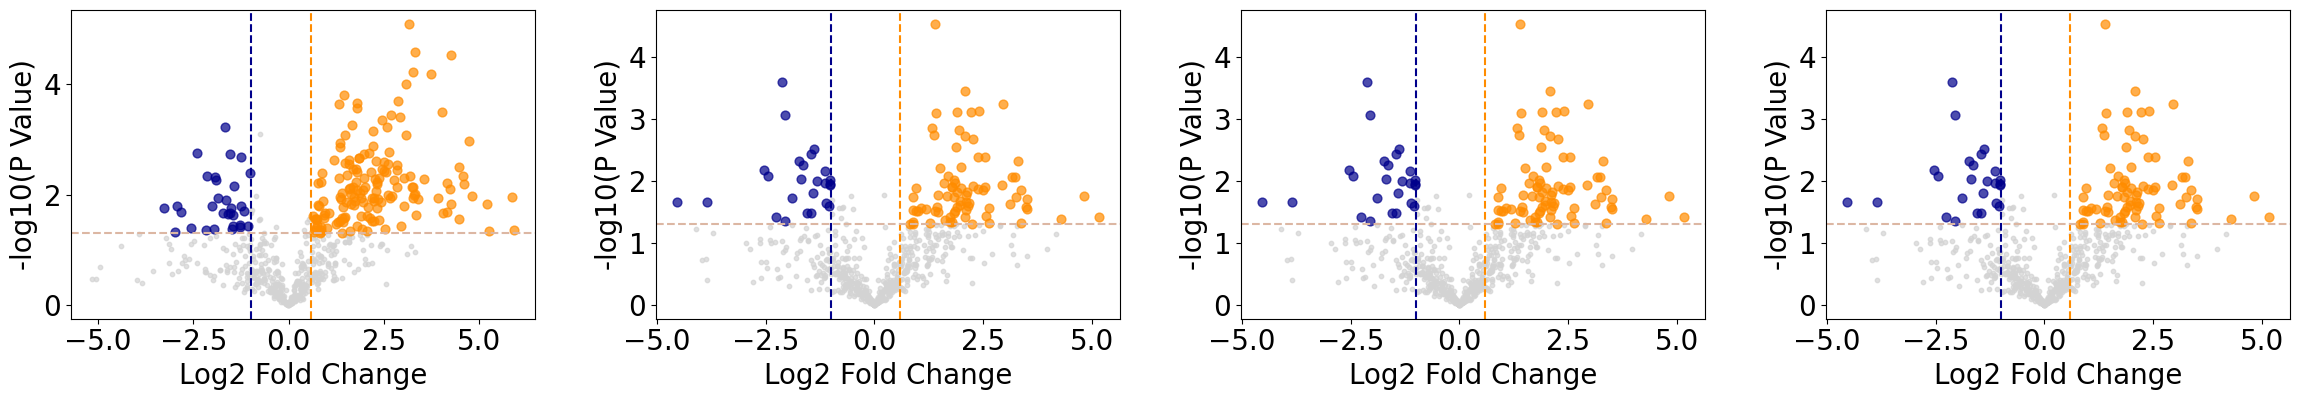

In [24]:
data_list = [sFEnD1_vs_sFED1, sFEnD2_vs_sFED2, sFEnD2_vs_sFED2, sFEnD2_vs_sFED2]
volcano_path = "/Users/bowen/Desktop/multi_omics_analysis/2408_pea 2/scripts/240924_Enrichment_Result/sFEn_vs_sFE/volcano_plot.pdf"
plot_volcano(data_list, None, save_path=volcano_path)

### sMEn vs sME

In [25]:
sMEnD1_vs_sMED1 = compare_groups(df, 'sMEnD1', 'sMED1')
sMEnD2_vs_sMED2 = compare_groups(df, 'sMEnD2', 'sMED2')
sMEnD3_vs_sMED3 = compare_groups(df, 'sMEnD3', 'sMED3')
sMEnD4_vs_sMED4 = compare_groups(df, 'sMEnD4', 'sMED4')

# dam_sMEnD1_vs_sMED1 = get_dam(sMEnD1_vs_sMED1)
# dam_sMEnD2_vs_sMED2 = get_dam(sMEnD2_vs_sMED2)
# dam_sMEnD3_vs_sMED3 = get_dam(sMEnD3_vs_sMED3)
# dam_sMEnD4_vs_sMED4 = get_dam(sMEnD4_vs_sMED4)

# base_path = '/Users/bowen/Desktop/multi_omics_analysis/2408_pea 2/scripts/240628_Enrichment_Result/sMEn_vs_sME'

# # Define the file paths based on the base path
# path1 = os.path.join(base_path, 'sMEnD1_vs_sMED1/DAM_sMEnD1_vs_sMED1.csv')
# path2 = os.path.join(base_path, 'sMEnD2_vs_sMED2/DAM_sMEnD2_vs_sMED2.csv')
# path3 = os.path.join(base_path, 'sMEnD3_vs_sMED3/DAM_sMEnD3_vs_sMED3.csv')
# path4 = os.path.join(base_path, 'sMEnD4_vs_sMED4/DAM_sMEnD4_vs_sMED4.csv')

# os.makedirs(os.path.dirname(path1), exist_ok=True)
# os.makedirs(os.path.dirname(path2), exist_ok=True)
# os.makedirs(os.path.dirname(path3), exist_ok=True)
# os.makedirs(os.path.dirname(path4), exist_ok=True)

# dam_sMEnD1_vs_sMED1.to_csv(path1, index=False)
# dam_sMEnD2_vs_sMED2.to_csv(path2, index=False)
# dam_sMEnD3_vs_sMED3.to_csv(path3, index=False)
# dam_sMEnD4_vs_sMED4.to_csv(path4, index=False)

/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log2_Fold_Change'] = np.log2(df['Fold_Change'])
/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log2_Fold_Change'] = np.log2(df['Fold_Change'])
/var/folders/nd/ncfyt5nx5b34kdwm7z4dqrww0000gn/T/ipykernel_95329/135097932.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

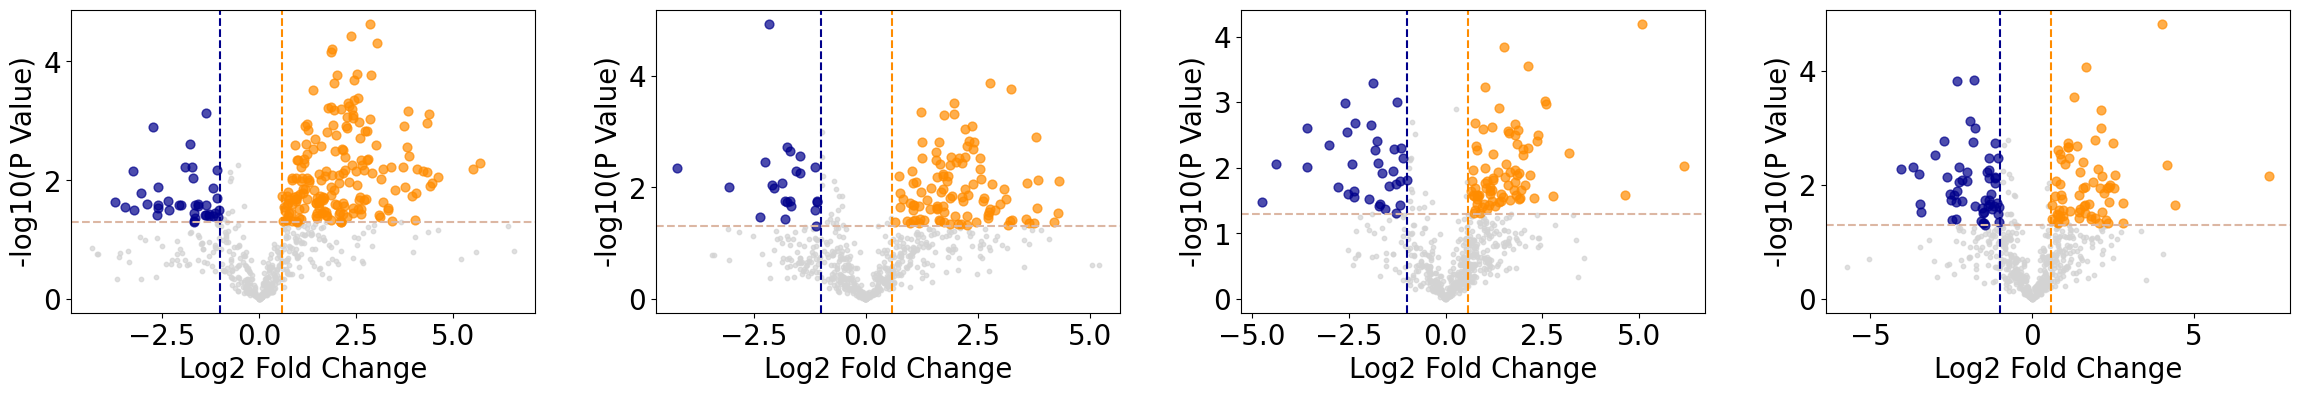

In [26]:
data_list = [sMEnD1_vs_sMED1, sMEnD2_vs_sMED2, sMEnD3_vs_sMED3, sMEnD4_vs_sMED4]
volcano_path = "/Users/bowen/Desktop/multi_omics_analysis/2408_pea 2/scripts/240924_Enrichment_Result/sMEn_vs_sME/volcano_plot.pdf"
plot_volcano(data_list, None, save_path=volcano_path)